In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [4]:
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
from src.toolbox.utils import _nms
from src.toolbox.eval import evaluate, location_error, accumulate_metrics, categorize_results, summarize_results_per_class
from src.toolbox.utils import _nms
from src.toolbox.visualization import plot_performance_per_class, plot_performance_per_duration
from src.toolbox.data_converters import ActivityNetCap2Instances
import seaborn as sns
sns.set()
import json
import pickle as pkl
import neptune
import os
sns.set_style("white")

In [5]:
raw_data = json.load(open("data/raw/ActivityNet/val_2.json"))
test_data = ActivityNetCap2Instances(raw_data)

In [6]:
project = neptune.init("mayu-ot/moment-retrieval")
if not os.path.exists("tmp/MOM-48/TAN_c3d_test.pkl"):
    exps = project.get_experiments(id="MOM-48")
    print("downloading results ...")
    exps[0].download_artifact("TAN_c3d_test.pkl", "tmp/MOM-48/")
    print("done!")

In [7]:
predictions = pkl.load(open("tmp/MOM-48/TAN_c3d_test.pkl", "rb"))
preds = []
for p in predictions:
    query = p[0][0], p[0][1]
    seg = p[1]
    keep = _nms(np.asarray(seg), np.arange(len(seg))[::-1], thresh=0.5, top_k=5)
    seg = [seg[i] for i in keep]
    preds.append((query, seg, np.arange(len(seg))[::-1].tolist()))
results = evaluate(test_data, preds)
summary = accumulate_metrics(results)

R@1 IoU>0.3 0.59
R@1 IoU>0.5 0.44
R@1 IoU>0.7 0.27
R@5 IoU>0.3 0.86
R@5 IoU>0.5 0.77
R@5 IoU>0.7 0.62
R@10 IoU>0.3 0.86
R@10 IoU>0.5 0.77
R@10 IoU>0.7 0.62


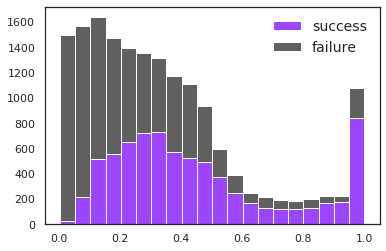

In [8]:
# Check relation between success rates and iput video durations
plt.rcParams.update({'font.size': 14})
fig = plot_performance_per_duration(results, test_data, ax=plt.gca())

In [9]:
# per-action performance
from src.toolbox.eval import get_first_action, categorize_results, summarize_results_per_class
from src.toolbox.utils import _load_top_actions
top_actions = _load_top_actions("activitynet")
cat_fn = lambda x: get_first_action(x, top_actions)
categorized_results = categorize_results(results, cat_fn)
metrics_per_cls = summarize_results_per_class(categorized_results)

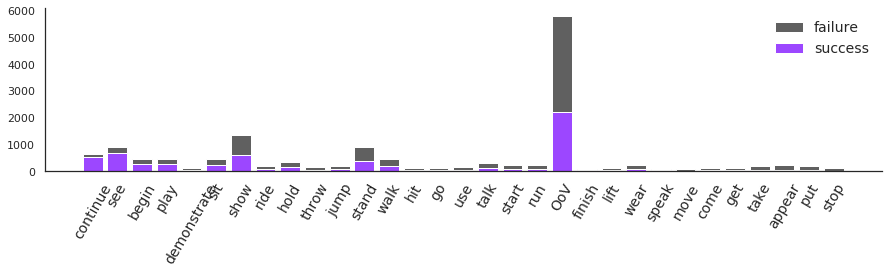

In [10]:
class_labels = list(metrics_per_cls.keys())
frequent_class = [label for label in class_labels if metrics_per_cls[label]["n_instance"] > 100]
_ = plot_performance_per_class({l: v for l, v in metrics_per_cls.items() if l in frequent_class})